In [1]:
from matplotlib import pyplot as plt
import numpy as np
from torch import optim
import time
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import torch.nn as nn
import torch
import pandas as pd
from collections import defaultdict
import string

In [2]:
# knock80をまとめたもの
class make_and_translate_ID():
    def __init__(self, data):
        self.train_dict = defaultdict(int)
        self.id_list = []
        self.id_dict = dict()
        self.make_id(data)

    def make_id(self, data):
        for line in data:
            words = line.translate(table).split()
            for word in words:
                self.train_dict[word] += 1
        calc_dict = dict(self.train_dict)
        sort_list = sorted(calc_dict.items(), key=lambda x: x[1], reverse=True)
        for i, (trg_word, freq) in enumerate(sort_list):
            if freq >= 2:
                self.id_list.append((trg_word, i+1))
            else:
                self.id_list.append((trg_word, 0))
        self.id_dict = dict(self.id_list)

    def return_id(self, line):
        one_hot_vec = []
        words = line.strip().split(" ")
        for word in words:
            if word in self.id_dict.keys():
                one_hot_vec.append(self.id_dict[word])
            else:
                one_hot_vec.append(0)
        return one_hot_vec

In [3]:
#全ての句読点文字をスペースに置き換える翻訳テーブル
table = str.maketrans(string.punctuation, ' '*len(string.punctuation))
header_name = ['TITLE', 'CATEGORY']
train_data = pd.read_csv("../chapter06/train.txt", header=None,sep='\t', names=header_name)

In [4]:
w2id = make_and_translate_ID(train_data["TITLE"])
test_vec = w2id.return_id(train_data["TITLE"][10])
print(train_data["TITLE"][10])
print(test_vec)

UPDATE 3-Big US banks' funding advantage reduced, could rise in crisis-official
[4, 0, 7, 0, 3046, 5175, 0, 175, 123, 3, 0]


In [5]:
# knock81より
class RNN(nn.Module):
    def __init__(self, hidden_size, vocab_size, emb_size, pad_idx, output_size, device):
        super().__init__()
        self.hid_size = hidden_size
        self.emb = nn.Embedding(vocab_size, emb_size, padding_idx=pad_idx)
        self.rnn = nn.RNN(emb_size, hidden_size,
                          nonlinearity="tanh", batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        self.batch_size = x.size()[0]
        hidden = torch.zeros(1, self.batch_size, self.hid_size, device=device)
        emb = self.emb(x)
        out, hidden = self.rnn(emb, hidden)
        out = self.fc(out[:, -1, :])
        return out

In [6]:
# knock81より
class NewsDataset(Dataset):
    def __init__(self, x, y, tokenizer):
        self.x = x
        self.y = y
        self.tokenizer = tokenizer#文字列を数値変換する

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        text = self.x[idx]
        inputs = self.tokenizer(text)

        return {
            'inputs': torch.tensor(inputs, dtype=torch.int64),
            'labels': torch.tensor(self.y[idx], dtype=torch.int64)
        }

In [7]:
train = pd.read_csv("../chapter06/train.txt", sep='\t')
valid = pd.read_csv("../chapter06/valid.txt", sep='\t')
test = pd.read_csv("../chapter06/test.txt", sep='\t')

category = {'b': 0, 't': 1, 'e': 2, 'm': 3}
y_train = torch.tensor(train['CATEGORY'].map(lambda x: category[x]).values)
y_valid = torch.tensor(valid['CATEGORY'].map(lambda x: category[x]).values)
y_test = torch.tensor(test['CATEGORY'].map(lambda x: category[x]).values)

dataset_train = NewsDataset(train["TITLE"], y_train, w2id.return_id)
dataset_valid = NewsDataset(valid["TITLE"], y_valid, w2id.return_id)
dataset_test = NewsDataset(test["TITLE"], y_test, w2id.return_id)

In [8]:
# knock82より
# 損失の正解率の計算
def calc_loss_and_acc(model, dataset, device=None, criterion=None):
    # model.eval()
    dataloader = DataLoader(dataset, batch_size=1, shuffle=False)
    loss = 0.0
    total = 0
    correct = 0
    with torch.no_grad():
        for data in dataloader:
            inputs = data["inputs"].to(device)
            labels = data["labels"].to(device)
            outputs = model(inputs)

            if criterion != None:
                loss += criterion(outputs, labels).item()

            pred = torch.argmax(outputs, dim=-1)
            total += len(inputs)
            correct += (pred == labels).sum().item()

        return loss / len(dataset), correct / total

In [13]:
# knock82より
# 学習する
def train_model(dataset_train, dataset_valid, batch_size, model, criterion,  optimizer, num_epochs, device=None, collate_fn=None):
    model.to(device)

    dataloader_train = DataLoader(
        dataset_train, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
    dataloader_valid = DataLoader(
        dataset_valid, batch_size=1, shuffle=False)
    # dataloader_valid = DataLoader(
    #     dataset_valid, batch_size=len(dataset_valid), shuffle=False)

    log_train = []
    log_valid = []

    for epoch in range(num_epochs):
        start_time = time.time()

        model.train()
        loss_train = 0.0
        for data in dataloader_train:
            optimizer.zero_grad()

            inputs = data["inputs"].to(device)
            labels = data["labels"].to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
        end_time = time.time()

        model.eval()
        loss_train, acc_train = calc_loss_and_acc(
            model, dataset_train, device, criterion=criterion)
        loss_valid, acc_valid = calc_loss_and_acc(
            model, dataset_valid, device, criterion=criterion)
        log_train.append([loss_train, acc_train])
        log_valid.append([loss_valid, acc_valid])

        torch.save({'epoch': epoch, 'model_state_dict': model.state_dict(
        ), 'optimizer_state_dict': optimizer.state_dict()}, f'./k83_saves/checkpoint{epoch + 1}.pt')

        print(f"epoch: {epoch+1},"
        f"loss_train: {loss_train:.4f},"
        f"accuracy_train: {acc_train:.4f},"
        f"loss_valid: {loss_valid:.4f},"
        f"accuracy_valid: {acc_valid:.4f},"
        f"train_time: {(end_time - start_time):.4f}sec")
    return {
        "train": log_train,
        "valid": log_valid
    }



In [14]:
# knock82より
#　損失，正解率の可視化
def make_graph_by_logs(log):
    fig, ax = plt.subplots(1, 2, figsize=(15, 5))
    ax[0].plot(np.array(log['train']).T[0], label='train')
    ax[0].plot(np.array(log['valid']).T[0], label='valid')
    ax[0].set_xlabel('epoch')
    ax[0].set_ylabel('loss')
    ax[0].legend()
    ax[1].plot(np.array(log['train']).T[1], label='train')
    ax[1].plot(np.array(log['valid']).T[1], label='valid')
    ax[1].set_xlabel('epoch')
    ax[1].set_ylabel('accuracy')
    ax[1].legend()
    plt.savefig("./graphs/knock83.png")

In [15]:
# ミニバッチ化，GPU上で計算
class Padseq():
    def __init__(self, padding_idx):
        self.padding_idx = padding_idx

    def __call__(self, batch):
        sorted_batch = sorted(
            batch, key=lambda x: x['inputs'].shape[0], reverse=True)
        sequences = [x['inputs'] for x in sorted_batch]
        sequences_padded = torch.nn.utils.rnn.pad_sequence(
            sequences, batch_first=True, padding_value=self.padding_idx)
        labels = torch.LongTensor([x['labels'] for x in sorted_batch])

        return {'inputs': sequences_padded, 'labels': labels}

/var/folders/1p/m23jt2g15kz8d77xv0qpzbt40000gn/T/ipykernel_28409/2980760911.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'labels': torch.tensor(self.y[idx], dtype=torch.int64)


epoch: 1,loss_train: 1.3166,accuracy_train: 0.4063,loss_valid: 1.3279,accuracy_valid: 0.4048,train_time: 5.2986sec
epoch: 2,loss_train: 1.2755,accuracy_train: 0.4211,loss_valid: 1.2877,accuracy_valid: 0.4183,train_time: 4.8529sec
epoch: 3,loss_train: 1.2203,accuracy_train: 0.4595,loss_valid: 1.2293,accuracy_valid: 0.4453,train_time: 4.8753sec
epoch: 4,loss_train: 1.2381,accuracy_train: 0.4826,loss_valid: 1.2553,accuracy_valid: 0.4708,train_time: 4.7408sec
epoch: 5,loss_train: 1.1124,accuracy_train: 0.5845,loss_valid: 1.1193,accuracy_valid: 0.5735,train_time: 4.7300sec
epoch: 6,loss_train: 1.2431,accuracy_train: 0.5139,loss_valid: 1.2661,accuracy_valid: 0.5045,train_time: 4.5892sec
epoch: 7,loss_train: 1.0554,accuracy_train: 0.6118,loss_valid: 1.0852,accuracy_valid: 0.5967,train_time: 4.5457sec
epoch: 8,loss_train: 1.0149,accuracy_train: 0.6478,loss_valid: 1.0394,accuracy_valid: 0.6252,train_time: 4.8427sec
epoch: 9,loss_train: 0.8723,accuracy_train: 0.7257,loss_valid: 0.9185,accuracy_v

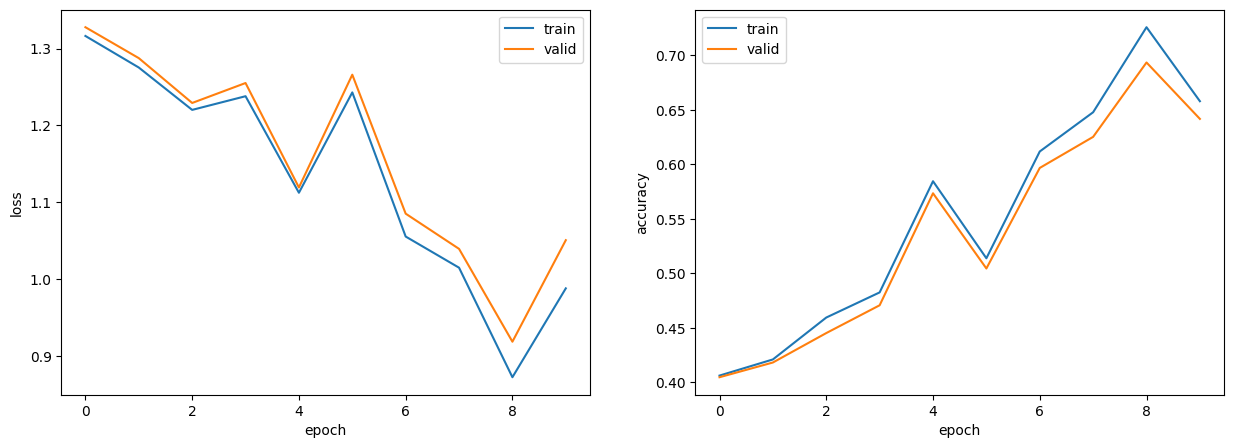

In [17]:
VOCAB_SIZE = len(set(w2id.id_dict.values())) + 1
EMB_SIZE = 300
PADDING_IDX = len(set(w2id.id_dict.values()))
OUTPUT_SIZE = 4
HIDDEN_SIZE = 50
LEARNING_RATE = 5e-2
BATCH_SIZE = 32
NUM_EPOCHS = 10

device = torch.device("mps")
model = RNN(HIDDEN_SIZE, VOCAB_SIZE, EMB_SIZE, PADDING_IDX, OUTPUT_SIZE, device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE)

log = train_model(dataset_train, dataset_valid, BATCH_SIZE, model, criterion,
                  optimizer, NUM_EPOCHS, device=device, collate_fn=Padseq(PADDING_IDX))

make_graph_by_logs(log)

# 損失と精度の計算
_, acc_train = calc_loss_and_acc(model, dataset_train, device)
_, acc_test = calc_loss_and_acc(model, dataset_test, device)

print(f'Train Accuracy: {acc_train:.3f}')
print(f'Test Accuracy: {acc_test:.3f}')